In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import geohash2
import matplotlib
from geopy.distance import geodesic
from concurrent.futures import ThreadPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

%matplotlib inline

d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv('Book.csv', encoding='ISO-8859-1')
df.head()

image      Date  \
0  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
1  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
2  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
3  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
4  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   

   DistributorCode               DistributorName  \
0            11660           Ananda Distributors   
1            11660           Ananda Distributors   
2            11660           Ananda Distributors   
3            11660           Ananda Distributors   
4            69737  SSK Distributors - Kadawatha   

                          SalesRep  repcode OutletCode Sector Outlet  \
0         Malaka Yakdehige- Horana      R16   IC107724           Yes   
1         Malaka Yakdehige- Horana      R16   IC006407           Yes   
2         Malaka Yakdehige- Horana      R16   IC006917           Yes   
3         Malaka Yakdehige- Horana      R16   IC007542           Yes   
4  D.P Hansala Charuka - Kadawatha  REP0584   SD106461           Yes   

        OutletName                                          routename  \
0   Hemantha Super  Padukka Road, Kananwila,Wattekade up to Olabud...   
1     Anura Stores  Padukka Road, Kananwila,Wattekade up to Olabud...   
2  Samantha Stores  Padukka Road, Kananwila,Wattekade up to Olabud...   
3      S.S. Stores  Padukka Road, Kananwila,Wattekade up to Olabud...   
4    Ranga Grocery                               DSR 2 69737 Route 19   

                     RepName       RepId  Longitude  Latitude  IsGPSOn  \
0     Malaka Yakdehige 11660   DSR001405   80.05333   6.75254     True   
1     Malaka Yakdehige 11660   DSR001405   80.05340   6.75157     True   
2     Malaka Yakdehige 11660   DSR001405   80.05466   6.74143     True   
3     Malaka Yakdehige 11660   DSR001405   80.06525   6.71385     True   
4  D.P Hansala Charuka 69737  DSR0001068   79.95640   7.02132     True   

        Key  
0  SMMT1364  
1  SMMT1854  
2   SMMT398  
3   SMMT485  
4   SMMT386

In [3]:
df.shape

(5092, 16)

In [4]:
df = df.drop_duplicates()

In [ ]:
df.shape

(5086, 16)

In [6]:
df = df[~((df['Longitude'] == 0.0) & (df['Latitude'] == 0.0))]
df.reset_index(drop=True, inplace=True)

In [7]:
df.shape

(4926, 16)

In [8]:
def lat_lon_to_geohash(lat, lon, precision=4):
    return geohash2.encode(lat, lon, precision)

In [9]:
df['geohash'] = df.apply(lambda row: lat_lon_to_geohash(row['Latitude'], row['Longitude']), axis=1)

In [10]:
geohash_counts = df['geohash'].value_counts().reset_index()
geohash_counts.columns = ['geohash', 'count']

In [11]:
geohash_counts['cluster_number'] = geohash_counts.index + 1 

In [12]:
merged_df = df.merge(geohash_counts[['geohash', 'cluster_number', 'count']], on='geohash', how='inner')

In [13]:
merged_df.head()

image      Date  \
0  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
1  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
2  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
3  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   
4  https://surge.keells.lk/Myfiles/RetailerImages...  8/1/2024   

   DistributorCode               DistributorName  \
0            11660           Ananda Distributors   
1            11660           Ananda Distributors   
2            11660           Ananda Distributors   
3            11660           Ananda Distributors   
4            69737  SSK Distributors - Kadawatha   

                          SalesRep  repcode OutletCode Sector Outlet  \
0         Malaka Yakdehige- Horana      R16   IC107724           Yes   
1         Malaka Yakdehige- Horana      R16   IC006407           Yes   
2         Malaka Yakdehige- Horana      R16   IC006917           Yes   
3         Malaka Yakdehige- Horana      R16   IC007542           Yes   
4  D.P Hansala Charuka - Kadawatha  REP0584   SD106461           Yes   

        OutletName                                          routename  \
0   Hemantha Super  Padukka Road, Kananwila,Wattekade up to Olabud...   
1     Anura Stores  Padukka Road, Kananwila,Wattekade up to Olabud...   
2  Samantha Stores  Padukka Road, Kananwila,Wattekade up to Olabud...   
3      S.S. Stores  Padukka Road, Kananwila,Wattekade up to Olabud...   
4    Ranga Grocery                               DSR 2 69737 Route 19   

                     RepName       RepId  Longitude  Latitude  IsGPSOn  \
0     Malaka Yakdehige 11660   DSR001405   80.05333   6.75254     True   
1     Malaka Yakdehige 11660   DSR001405   80.05340   6.75157     True   
2     Malaka Yakdehige 11660   DSR001405   80.05466   6.74143     True   
3     Malaka Yakdehige 11660   DSR001405   80.06525   6.71385     True   
4  D.P Hansala Charuka 69737  DSR0001068   79.95640   7.02132     True   

        Key geohash  cluster_number  count  
0  SMMT1364    tc0y               1    600  
1  SMMT1854    tc0y               1    600  
2   SMMT398    tc0y               1    600  
3   SMMT485    tc0y               1    600  
4   SMMT386    tc0z               2    577

In [14]:
merged_df['cluster_number'].value_counts()

cluster_number
1      600
2      577
3      491
4      275
5      204
      ... 
96       2
97       2
98       1
99       1
100      1
Name: count, Length: 100, dtype: int64

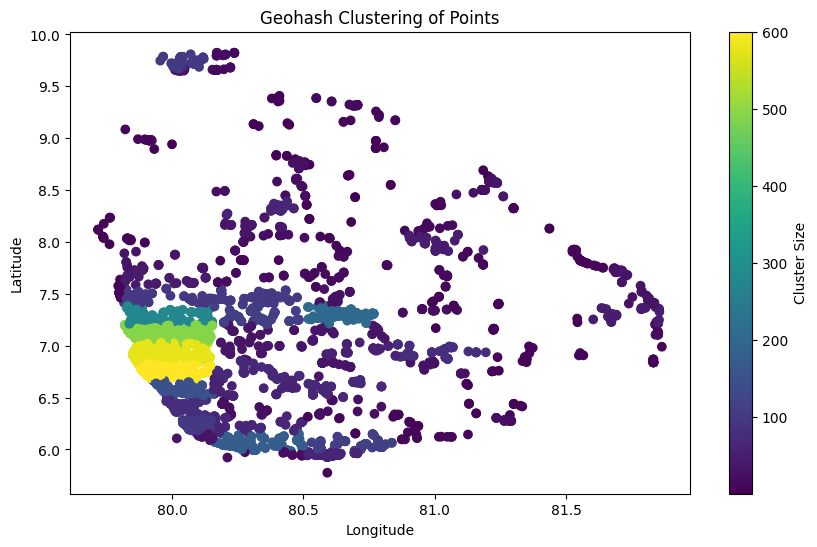

In [15]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['count'], cmap='viridis', marker='o')
plt.colorbar(scatter, label='Cluster Size')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geohash Clustering of Points')
plt.show()

In [16]:
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)


num_clusters = geohash_counts['cluster_number'].max()
cmap = plt.get_cmap('Spectral', num_clusters) 
colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(num_clusters)]


for _, row in merged_df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=5,  
        color=colors[row['cluster_number'] - 1],  
        fill=True,
        fill_opacity=0.6,
        popup=f'Cluster: {row["cluster_number"]}, Count: {row["count"]}' 
    ).add_to(m)

m

In [17]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

In [18]:
calculate_distance(7.26438
,79.85898
, 7.26437
,79.85895
)

3.492669106286937

In [19]:
calculate_distance(7.26438,79.85898,7.26462, 79.85928)

42.45055460929799

In [20]:
calculate_distance(7.26438,79.85898,7.26779, 79.86113)

445.6349464873775

In [49]:
def sentence_bert_similarity(texts):
    model = SentenceTransformer('all-MiniLM-L6-v2')  # A smaller BERT variant for efficiency
    embeddings = model.encode(texts, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings, embeddings)
    return similarity

In [50]:
threshold = 0.80  
distance_threshold = 200
processed_clusters = []
group_counter = 1  

for cluster_number, cluster_df in merged_df.groupby('cluster_number'):
    cluster_df.reset_index(inplace=True, drop=True)    
    cluster_df['same_shop_group'] = pd.NA 

    if len(cluster_df) == 1:
        cluster_df['same_shop_group'] = group_counter
        group_counter += 1
        processed_clusters.append(cluster_df)
        continue

    assign_shops = set()

    cluster_df['OutletNameNew'] = cluster_df['OutletName'].apply(lambda x: ' '.join(x.strip().split()[:1]))
    sentences = cluster_df['OutletNameNew'].to_list()
    similarity_matrix = sentence_bert_similarity(sentences)


    for i in range(len(similarity_matrix)):
        if pd.isna(cluster_df.iloc[i]['same_shop_group']) and cluster_df.index[i] not in assign_shops:
            cluster_df.loc[cluster_df.index[i], 'same_shop_group'] = group_counter

            assign_shops.add(cluster_df.index[i])

            for j in range(i,len(similarity_matrix)):
                if i != j and similarity_matrix[i][j] > threshold:
                    lat1, lon1 = cluster_df.iloc[i][['Latitude', 'Longitude']]
                    lat2, lon2 = cluster_df.iloc[j][['Latitude', 'Longitude']]
                    distance = calculate_distance(lat1, lon1, lat2, lon2)

                    if distance < distance_threshold:
                        if pd.isna(cluster_df.iloc[j]['same_shop_group']):
                            cluster_df.loc[cluster_df.index[j], 'same_shop_group'] = group_counter
                            assign_shops.add(cluster_df.index[j])

            
            group_counter += 1

    processed_clusters.append(cluster_df)
    print(f'{cluster_number} has procceded')

d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


2 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


3 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


4 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


5 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


6 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


7 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


8 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


9 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


10 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


11 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


12 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


13 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


14 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


15 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


16 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


17 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


18 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


19 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


20 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


21 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


22 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


23 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


24 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


25 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


26 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


27 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


28 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


29 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


30 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


31 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


32 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


33 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


34 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


35 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


36 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


37 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


38 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


39 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


40 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


41 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


42 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


43 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


44 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


45 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


46 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


47 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


48 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


49 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


50 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


51 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


52 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


53 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


54 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


55 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


56 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


57 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


58 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


59 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


60 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


61 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


62 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


63 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


64 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


65 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


66 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


67 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


68 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


69 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


70 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


71 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


72 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


73 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


74 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


75 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


76 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


77 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


78 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


79 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


80 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


81 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


82 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


83 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


84 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


85 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


86 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


87 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


88 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


89 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


90 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


91 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


92 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


93 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


94 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


95 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


96 has procceded


d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


97 has procceded


In [51]:
final_df = pd.concat(processed_clusters)
final_df = final_df.reset_index(drop=True)

In [52]:
final_df = final_df.dropna(subset=['OutletName', 'Longitude', 'Latitude'])

In [53]:
final_df

image       Date  \
0     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
1     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
2     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
3     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
4     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
...                                                 ...        ...   
4921  https://surge.keells.lk/Myfiles/RetailerImages...  9/19/2024   
4922  https://surge.keells.lk/Myfiles/RetailerImages...  9/28/2024   
4923  https://surge.keells.lk/Myfiles/RetailerImages...  9/13/2024   
4924  https://surge.keells.lk/Myfiles/RetailerImages...  9/19/2024   
4925  https://surge.keells.lk/Myfiles/RetailerImages...  9/26/2024   

      DistributorCode                     DistributorName  \
0               11660                 Ananda Distributors   
1               11660                 Ananda Distributors   
2               11660                 Ananda Distributors   
3               11660                 Ananda Distributors   
4               66478             Origin Holdings Pvt Ltd   
...               ...                                 ...   
4921             6159                   Harry Trading Co.   
4922            64983  Sakalasooriya Traders  & Rice Mill   
4923             5961    Piyasiri Stores & Marketing Pvt.   
4924            70271                  Ranjan Cream House   
4925            21426                  Vithu Distributors   

                                 SalesRep  repcode OutletCode Sector Outlet  \
0                Malaka Yakdehige- Horana      R16   IC107724           Yes   
1                Malaka Yakdehige- Horana      R16   IC006407           Yes   
2                Malaka Yakdehige- Horana      R16   IC006917           Yes   
3                Malaka Yakdehige- Horana      R16   IC007542           Yes   
4     H Charith Kavinda - Moratuwa (OHPL)     R489   IC107146           Yes   
...                                   ...      ...        ...           ...   
4921           S Dinesh - Batticoloa (HT)      R80   IC066139           Yes   
4922               R. M Rafnas - Kanthale  REP0648   SD265083           Yes   
4923    Sameera Kumara - Denipitiya (PSM)      R50   IC014082           Yes   
4924  D M Gayan Kaushalya - Badulla (RCH)     R530   IC085106           Yes   
4925         S.Tharusanan - Vavuniya (VD)     R329   IC038374           Yes   

                       OutletName  \
0                  Hemantha Super   
1                    Anura Stores   
2                 Samantha Stores   
3                     S.S. Stores   
4                 The Good Farmer   
...                           ...   
4921  Army Welfare Shop (Waharai)   
4922                223 ARMY CAMP   
4923           Gunawardana Stores   
4924                 R.M.D Stoers   
4925           MaKenthiran stores   

                                              routename  ...       RepId  \
0     Padukka Road, Kananwila,Wattekade up to Olabud...  ...   DSR001405   
1     Padukka Road, Kananwila,Wattekade up to Olabud...  ...   DSR001405   
2     Padukka Road, Kananwila,Wattekade up to Olabud...  ...   DSR001405   
3     Padukka Road, Kananwila,Wattekade up to Olabud...  ...   DSR001405   
4     Dehiwala Junction up to Maliban Junction, Gall...  ...  DSR0001190   
...                                                 ...  ...         ...   
4921                         Siththandy Up to Pasikudha  ...   DSR000654   
4922                                            Vaharai  ...  DSR0001161   
4923          Kamburugamuwa Up To Polhena Nupe Junction  ...  DSR0012731   
4924       Spring Valley Road, Viharagoda, Badulupitiya  ...  DSR0001351   
4925                          Nedunkeni up to Iranamadu  ...   DSR000878   

     Longitude  Latitude  IsGPSOn       Key geohash cluster_number  count  \
0     80.05333   6.75254     True  SMMT1364    tc0y              1    600   
1     80.05340 

In [54]:
merged_df.shape

(4926, 19)

In [55]:
final_df.shape

(4926, 21)

In [56]:
final_df.same_shop_group.value_counts()

same_shop_group
1181    6
2720    6
389     5
885     5
62      5
       ..
1707    1
1708    1
1709    1
1710    1
3358    1
Name: count, Length: 3358, dtype: int64

In [58]:
final_df[final_df.same_shop_group==2720]

image       Date  \
4058  https://surge.keells.lk/Myfiles/RetailerImages...  9/10/2024   
4061  https://surge.keells.lk/Myfiles/RetailerImages...  9/10/2024   
4076  https://surge.keells.lk/Myfiles/RetailerImages...  9/16/2024   
4077  https://surge.keells.lk/Myfiles/RetailerImages...  9/16/2024   
4078  https://surge.keells.lk/Myfiles/RetailerImages...  9/17/2024   
4083  https://surge.keells.lk/Myfiles/RetailerImages...  9/30/2024   

      DistributorCode           DistributorName  \
4058            63161              S S K Agency   
4061            63161              S S K Agency   
4076            68065  Devasi Dealers (PVT) LTD   
4077            68065  Devasi Dealers (PVT) LTD   
4078            58385                SSK Agency   
4083            68065  Devasi Dealers (PVT) LTD   

                                               SalesRep        repcode  \
4058                  R.Wasantha Ruban - Kotagala (SSK)            R73   
4061                  R.Wasantha Ruban - Kotagala (SSK)            R73   
4076  NAWALAPITIYA Anjana Yasas Marasingha (D) - 124698  68065KFPREP01   
4077  NAWALAPITIYA Anjana Yasas Marasingha (D) - 124698  68065KFPREP01   
4078                       RAJKUMAR RAMANATHAN - Hatton        REP0200   
4083  NAWALAPITIYA Anjana Yasas Marasingha (D) - 124698  68065KFPREP01   

     OutletCode Sector Outlet            OutletName               routename  \
4058   IC076097           Yes  New Lanka super city  Norwood Up To Maskeliy   
4061   IC028655           Yes         New Samanpura  Norwood Up To Maskeliy   
4076   KF014800           Yes  New Samanpura Stores               Maskeliya   
4077   KF034478           Yes       NEW LANKA SUPER               Maskeliya   
4078   SD286623           Yes     NEW LANKA TRADERS    DSR 2 58385 Route 11   
4083   KF014800           Yes  New Samanpura Stores               Maskeliya   

      ...          RepId Longitude  Latitude  IsGPSOn      Key geohash  \
4058  ...      DSR000495  80.57233   6.83420     True  SMMT150    tc1q   
4061  ...      DSR000495  80.57177   6.83492     True  SMMT152    tc1q   
4076  ...  68065KFPCSR01  80.57148   6.83496     True  SMMT152    tc1q   
4077  ...  68065KFPCSR01  80.57234   6.83418     True  SMMT150    tc1q   
4078  ...      DSR002238  80.57230   6.83421     True  SMMT150    tc1q   
4083  ...  68065KFPCSR01  80.57141   6.83508     True  SMMT152    tc1q   

     cluster_number  count  same_shop_group OutletNameNew  
4058             32     32             2720           New  
4061             32     32             2720           New  
4076             32     32             2720           New  
4077             32     32             2720           NEW  
4078             32     32             2720           NEW  
4083             32     32             2720           New  

[6 rows x 21 columns]

In [59]:
sentence_bert_similarity(['Lanka Sathosa - Baddegama','Lanka sathosa - Elpitiya','Cargills FC KELANIYA 2','Cargills FC GOTHATUWA IDH'])

d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tensor([[1.0000, 0.8469, 0.2942, 0.2993],
        [0.8469, 1.0000, 0.3025, 0.3215],
        [0.2942, 0.3025, 1.0000, 0.7939],
        [0.2993, 0.3215, 0.7939, 1.0000]])

In [31]:
# final_df.drop(['index'], axis=1, inplace=True)

In [60]:
final_df.to_csv('final_Book_6.csv', index=False)

In [61]:
count_group = final_df.same_shop_group.value_counts()

In [62]:
count_ind = count_group[count_group>1].index

In [63]:
count_df = final_df[final_df['same_shop_group'].isin(count_ind)]

In [64]:
count_df.reset_index(drop=True,inplace=True)

In [65]:
count_df

image       Date  \
0     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
1     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
2     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
3     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
4     https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
...                                                 ...        ...   
2584  https://surge.keells.lk/Myfiles/RetailerImages...  9/20/2024   
2585  https://surge.keells.lk/Myfiles/RetailerImages...  9/13/2024   
2586  https://surge.keells.lk/Myfiles/RetailerImages...  9/23/2024   
2587  https://surge.keells.lk/Myfiles/RetailerImages...  9/17/2024   
2588  https://surge.keells.lk/Myfiles/RetailerImages...  9/18/2024   

      DistributorCode                       DistributorName  \
0               11660                   Ananda Distributors   
1               11660                   Ananda Distributors   
2               11660                   Ananda Distributors   
3               66478               Origin Holdings Pvt Ltd   
4               66478               Origin Holdings Pvt Ltd   
...               ...                                   ...   
2584            64228                 Darshana Distributors   
2585             7407                    Nanda Distributors   
2586            69561                         Harry Traders   
2587            71037  Maduwantha Distributor - Mihintale..   
2588            70091             New Rajarata Distributor    

                                       SalesRep        repcode OutletCode  \
0                      Malaka Yakdehige- Horana            R16   IC107724   
1                      Malaka Yakdehige- Horana            R16   IC006407   
2                      Malaka Yakdehige- Horana            R16   IC006917   
3           H Charith Kavinda - Moratuwa (OHPL)           R489   IC107146   
4           H Charith Kavinda - Moratuwa (OHPL)           R489   IC100061   
...                                         ...            ...        ...   
2584       Wellawaya Kasun Lakshan (D) - 116772  64228KFPREP02   KF039216   
2585             H L G Jayarathna - Trincomalee        REP0241   SD340474   
2586         Trincomalee Main Zarfan (H)-128100  69561KFPREP02   KF088202   
2587       K.G Siyantha Wickramage - Mihinthale           R522   IC044992   
2588  D.K.G.Tharusha jayarathna - Medawachchiya        REP0804   SD329652   

     Sector Outlet         OutletName  \
0              Yes     Hemantha Super   
1              Yes       Anura Stores   
2              Yes    Samantha Stores   
3              Yes    The Good Farmer   
4              Yes        Metro Super   
...            ...                ...   
2584           Yes         King Super   
2585           Yes  Raja supar market   
2586           Yes  Raja Super Market   
2587           Yes      Thilak Supper   
2588           Yes       Thilak super   

                                              routename  ...          RepId  \
0     Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
1     Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
2     Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
3     Dehiwala Junction up to Maliban Junction, Gall...  ...     DSR0001190   
4     Dehiwala Junction up to Maliban Junction, Gall...  ...     DSR0001190   
...                                                 ...  ...            ...   
2584                                            Kudaoya  ...  64228KFPCSR02   
2585                  3rd Mile Post Up To 7th Mail Post  ...      DSR001165   
2586                        Allesh Garden upto Nilaweli  ...  69561KFPCSR02   
2587                Kekirawa Juction Up to Horowpathana  ...     DSR0001317   
2588                               DSR 3 70091 Route 14  ...     DSR0001376   

     Longitude  Latitude  IsGPSOn       Key geohash cluster_number  count  \
0     80

In [66]:
"""count_df short by same_shop_group"""

count_df.sort_values(by='same_shop_group', ascending=False, inplace=True)
count_df = count_df.reset_index(drop=True)
count_df.head()
count_df.to_csv('Repeat_shops_book_6.csv', index=False)
"""
Calculate similarity between two shop names using Spacy.

This is a simple demonstration, a more sophisticated approach would involve using a more sophisticated NLP model, possibly a pre-trained model like BERT or GPT-3.

Please note that Spacy's similarity calculation method is not 100% accurate and may not be suitable for all use cases.
"""

C:\Users\PC\AppData\Local\Temp\ipykernel_11456\822467595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df.sort_values(by='same_shop_group', ascending=False, inplace=True)


"\nCalculate similarity between two shop names using Spacy.\n\nThis is a simple demonstration, a more sophisticated approach would involve using a more sophisticated NLP model, possibly a pre-trained model like BERT or GPT-3.\n\nPlease note that Spacy's similarity calculation method is not 100% accurate and may not be suitable for all use cases.\n"

In [67]:
count_df

image       Date  \
0     https://surge.keells.lk/Myfiles/RetailerImages...  9/18/2024   
1     https://surge.keells.lk/Myfiles/RetailerImages...  9/17/2024   
2     https://surge.keells.lk/Myfiles/RetailerImages...  9/23/2024   
3     https://surge.keells.lk/Myfiles/RetailerImages...  9/13/2024   
4     https://surge.keells.lk/Myfiles/RetailerImages...  9/20/2024   
...                                                 ...        ...   
2584  https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
2585  https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   
2586  https://surge.keells.lk/Myfiles/RetailerImages...   8/9/2024   
2587  https://surge.keells.lk/Myfiles/RetailerImages...   8/7/2024   
2588  https://surge.keells.lk/Myfiles/RetailerImages...   8/1/2024   

      DistributorCode                       DistributorName  \
0               70091             New Rajarata Distributor    
1               71037  Maduwantha Distributor - Mihintale..   
2               69561                         Harry Traders   
3                7407                    Nanda Distributors   
4               64228                 Darshana Distributors   
...               ...                                   ...   
2584            11660                   Ananda Distributors   
2585            11660                   Ananda Distributors   
2586            11660                   Ananda Distributors   
2587            11660                   Ananda Distributors   
2588            11660                   Ananda Distributors   

                                       SalesRep        repcode OutletCode  \
0     D.K.G.Tharusha jayarathna - Medawachchiya        REP0804   SD329652   
1          K.G Siyantha Wickramage - Mihinthale           R522   IC044992   
2            Trincomalee Main Zarfan (H)-128100  69561KFPREP02   KF088202   
3                H L G Jayarathna - Trincomalee        REP0241   SD340474   
4          Wellawaya Kasun Lakshan (D) - 116772  64228KFPREP02   KF039216   
...                                         ...            ...        ...   
2584                   Malaka Yakdehige- Horana            R16   IC006917   
2585                   Malaka Yakdehige- Horana            R16   IC006407   
2586                   Malaka Yakdehige- Horana            R16   IC006407   
2587                   Malaka Yakdehige- Horana            R16   IC107724   
2588                   Malaka Yakdehige- Horana            R16   IC107724   

     Sector Outlet         OutletName  \
0              Yes       Thilak super   
1              Yes      Thilak Supper   
2              Yes  Raja Super Market   
3              Yes  Raja supar market   
4              Yes         King Super   
...            ...                ...   
2584           Yes    Samantha Stores   
2585           Yes       Anura Stores   
2586           Yes       Anura Stores   
2587           Yes     Hemantha Super   
2588           Yes     Hemantha Super   

                                              routename  ...          RepId  \
0                                  DSR 3 70091 Route 14  ...     DSR0001376   
1                   Kekirawa Juction Up to Horowpathana  ...     DSR0001317   
2                           Allesh Garden upto Nilaweli  ...  69561KFPCSR02   
3                     3rd Mile Post Up To 7th Mail Post  ...      DSR001165   
4                                               Kudaoya  ...  64228KFPCSR02   
...                                                 ...  ...            ...   
2584  Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
2585  Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
2586  Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
2587  Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   
2588  Padukka Road, Kananwila,Wattekade up to Olabud...  ...      DSR001405   

     Longitude  Latitude  IsGPSOn       Key geohash cluster_number  count  \
0     80

In [46]:
import spacy

In [47]:
nlp = spacy.load("en_core_web_md")

In [44]:
shop_1 = count_df['OutletName'].to_list()[-1]
shop_2 = count_df['OutletName'].to_list()[-2]

print(f'{shop_1} and {shop_2}')

ARMY CAMP (Pasikudha) and Army Camp Stoll


In [42]:
doc1 = nlp(shop_1)
doc2 = nlp(shop_2)
similarity = doc1.similarity(doc2)

In [43]:
similarity

0.6962160468101501

In [55]:
doc1 = nlp('M.M shop')
doc2 = nlp('M.I shop')
similarity = doc1.similarity(doc2)
similarity

0.5949275493621826

In [37]:
sentence_bert_similarity( ['Anura Trade Center','Anura Super - Kochchikade','Anura Super Center(Pvt)'])

d:\ML-GPS\Image_Customer_List\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tensor([[1.0000, 0.4059, 0.5992],
        [0.4059, 1.0000, 0.5370],
        [0.5992, 0.5370, 1.0000]])